In [34]:
import pandas as pd
import numpy as np

# Data query
Infodengue's tables have data aggregated by week, provided by different sources. They could be consulted by a form, or directly from Python, via consult of an API. This functionality is available via the URL: https://info.dengue.mat.br/api/alertcity?params: must contain the following parameters:

* geocode: city's IBGE code
* disease: desease type to be consulted (str:dengue|chikungunya|zika)
* format: file extension/format (str:json|csv)
* ew_start: epidemiological week initial consultation (int:1-53)
* ew_end: epidemiological week final consultation (int:1-53)
* ey_start: year of initial consultation (int:0-9999)
* ey_end: year of final consultation (int:0-9999)

Every parameter mentioned so far is obligatory for the consultation. The following example shows the requisition of the register of dengue between 1 and 52 of the year 2020, in Rio de Janeiro (geocodigo = 3304557) on CSV: https://info.dengue.mat.br/api/alertcity?geocode=3304557&disease=dengue&format=csv&ew_start=1&ew_end=52&ey_start=2021&ey_end=2021

In [35]:
ibge_codes = [
    4316907
]

In [36]:
def make_url(city_code,ew_start,ew_end,ey_start,ey_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = city_code
  disease = "dengue"
  format = "csv"
  ew_start = ew_start
  ew_end = ew_end
  ey_start = ey_start
  ey_end = ey_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])
  return url_resp

In [37]:
# Source: https://www.linuxquestions.org/questions/programming-9/python3-urlopen-error-%5Bssl-unsafe_legacy_renegotiation_disabled%5D-unsafe-legacy-renegotiation-disabled-_ssl-c-997-a-4175726636/#post6440291

import requests
import urllib3
import urllib.request
import ssl
import json

class CustomHttpAdapter (requests.adapters.HTTPAdapter):
    def __init__(self, ssl_context=None, **kwargs):
        self.ssl_context = ssl_context
        super().__init__(**kwargs)

    def init_poolmanager(self, connections, maxsize, block=False):
        self.poolmanager = urllib3.poolmanager.PoolManager(
            num_pools=connections, maxsize=maxsize,
            block=block, ssl_context=self.ssl_context)

def get_legacy_session():
    ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
    ctx.options |= 0x4
    session = requests.session()
    session.mount('https://', CustomHttpAdapter(ctx))
    return session

def ibge_request(URL, city_code):
  try:
      with get_legacy_session().get(URL + str(city_code)) as response:
          try:
              print("Fetch succeeded")
              return response.json()
          except:
              print("Fetch failed")

  except urllib.request.URLError as e:
      print(e)
      exit(1)

# api-endpoint
# get city name with IBGE code
URL = "https://servicodados.ibge.gov.br/api/v1/localidades/municipios/"

# sending get request and saving the response as response object
response = ibge_request(URL, 4316907)
response = ibge_request(URL, 3304557)

Fetch succeeded
Fetch succeeded


In [38]:
import plotly.graph_objects as go
from plotly.offline import iplot

def plot_city_data(city_data, city_name):
  dados = city_data
  trace1  = go.Scatter(
        mode='lines+markers',
        x=dados.index.map(
            lambda v: '%s' % (str(v)[-6:])
        ),
        y=dados['casos_est'],
        name="Estimated cases",
        marker_color='#1A5CF4',
        hovertemplate=(
            '%{text}' +
            '<br>' +
            '%{y:1f} Estimated cases' +
            '<extra></extra>'
        ),
        text="SE: " + dados.index.map(lambda v: '{}'.format(str(v)[-2:]))  +
            "<br>" +
            "Date: " + dados.data_iniSE.loc[dados.index],
        )

  trace2 = go.Bar(
          x=dados.index.map(
              lambda v: '%s' % (str(v)[-6:])
          ),
          y=dados['casos'],
          name="Reported cases",
          marker_color ='#BAF3FE',
          marker_line_color='rgb(8,48,107)',
          opacity=0.5,
          hovertemplate=(
              '%{text}' +
              '<br>' +
              '%{y:1f} Reported cases' +
              '<extra></extra>'
          ),
          text="SE: " + dados.index.map(lambda v: '{}'.format(str(v)[-2:]))  +
              "<br>" +
              "Date: " + dados.data_iniSE.loc[dados.index],
      )

  data = [trace1, trace2]

  layout = go.Layout(
      title_text='Total reported and estimated cases for '+str(city_name),
      yaxis=dict(
          title_text='Number of cases',
          side = 'left',
          showline=False,
          showgrid=True,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=0,
          gridcolor='rgb(176, 196, 222)',
      ),
      xaxis=dict(
          title_text='Epidemiological Week',
          showline=False,
          showgrid=True,
          showticklabels=True,
          tickangle=-60,
          linecolor='rgb(204, 204, 204)',
          linewidth=0,
          gridcolor='rgb(176, 196, 222)',

      ),
      showlegend=False,
      plot_bgcolor='rgb(255, 255, 255)',
      paper_bgcolor='rgb(245, 246, 249)',
      autosize=True,
  )

  fig = go.Figure(data=data, layout=layout)
  fig.show()

In [39]:
for city_code in ibge_codes:
  sm = pd.read_csv(make_url(city_code,1,53,2020,2024), index_col='SE')
  sm = sm.iloc[::-1]

  sm.to_csv("dados_infodengue_"+ str(city_code) + ".csv")
  plot_city_data(sm, ibge_request(URL, city_code)["nome"])

Fetch succeeded


# Gráfico do número de casos por ano

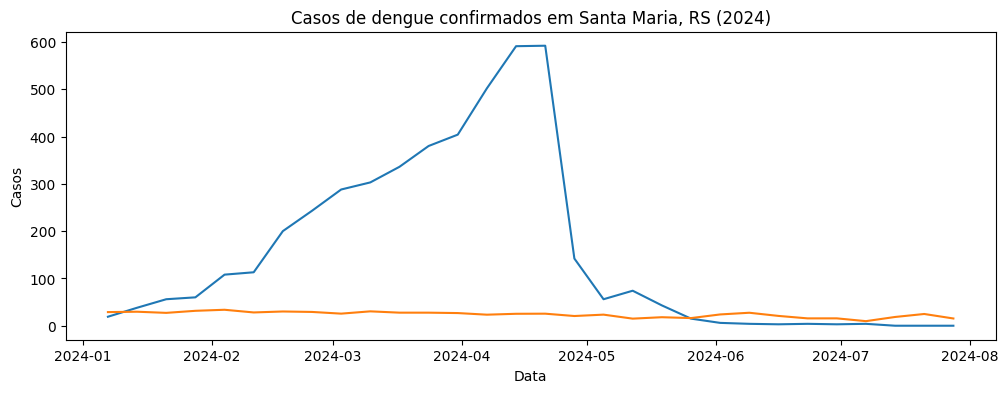

In [40]:
ano = 2024

sm['data_iniSE'] = pd.to_datetime(sm['data_iniSE'])
df_sm = sm[sm['data_iniSE'].dt.year == ano]

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the data from the first DataFrame
ax.plot(df_sm['data_iniSE'], df_sm['casos'], label='DataFrame 1')
ax.plot(df_sm['data_iniSE'], df_sm['tempmax'], label='DataFrame 1')

# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Casos')
ax.set_title(f'Casos de dengue confirmados em Santa Maria, RS ({ano})')

# Show the plot
plt.show()

# Rio de Janeiro

In [41]:
rj_ibge = 3304557

rj = pd.read_csv(make_url(rj_ibge,1,53,2020,2024), index_col='SE')
rj = rj.iloc[::-1]

rj.to_csv("dados_infodengue_"+ str(rj_ibge) + ".csv")
plot_city_data(rj, ibge_request(URL, rj_ibge)["nome"])

Fetch succeeded


In [42]:
rj = rj.iloc[:, :-6]
rj = rj.interpolate()
rj.isnull().sum()

<ipython-input-42-0c8b49a778b5>:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



,0
data_iniSE,0
casos_est,0
casos_est_min,0
casos_est_max,0
casos,0
p_rt1,0
p_inc100k,0
Localidade_id,0
nivel,0
id,0


##Comparação RJ e SM por ano

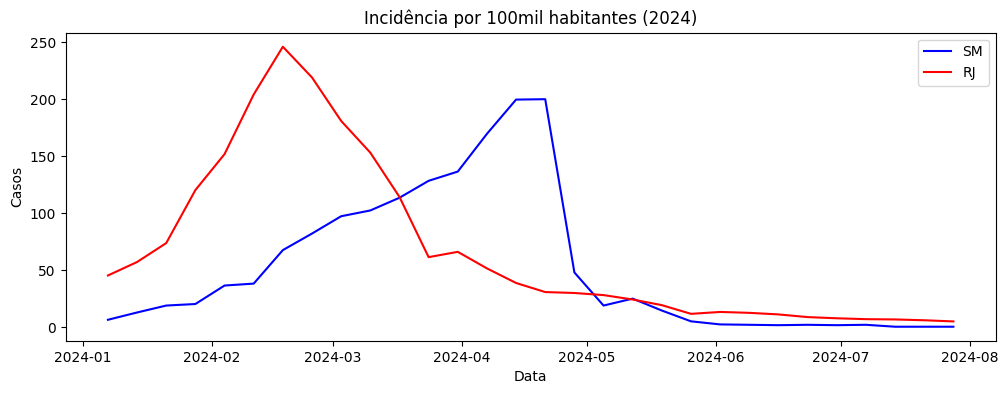

In [43]:
ano = 2024

sm['data_iniSE'] = pd.to_datetime(sm['data_iniSE'])
df_sm = sm[sm['data_iniSE'].dt.year == ano]

rj['data_iniSE'] = pd.to_datetime(rj['data_iniSE'])
df_rj = rj[rj['data_iniSE'].dt.year == ano]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the data from the first DataFrame
ax.plot(df_sm['data_iniSE'], df_sm['p_inc100k'], color='blue', label='SM')
ax.plot(df_rj['data_iniSE'], df_rj['p_inc100k'], color='red', label='RJ')

# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Casos')
ax.set_title(f'Incidência por 100mil habitantes ({ano})')

# Show the plot
plt.legend()
plt.show()

In [44]:
poa_ibge = 4314902

poa = pd.read_csv(make_url(poa_ibge,1,53,2020,2024), index_col='SE')
poa = poa.iloc[::-1]

poa.to_csv("dados_infodengue_"+ str(poa_ibge) + ".csv")
plot_city_data(poa, ibge_request(URL, poa_ibge)["nome"])

Fetch succeeded


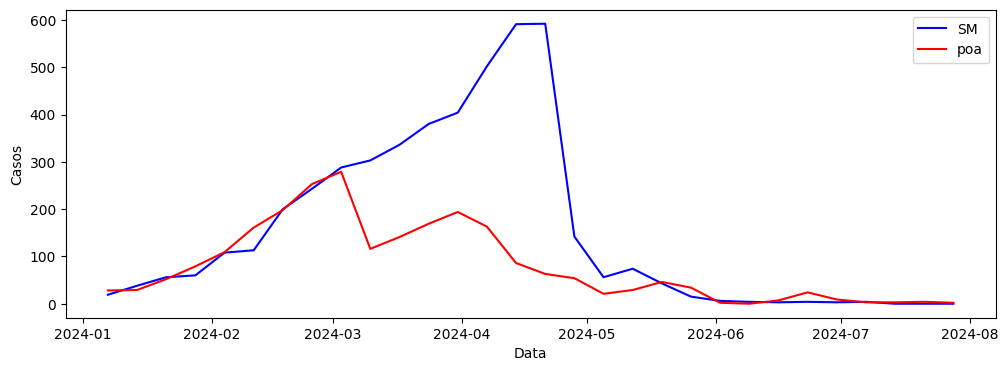

In [45]:
ano = 2024

sm['data_iniSE'] = pd.to_datetime(sm['data_iniSE'])
df_sm = sm[sm['data_iniSE'].dt.year == ano]

poa['data_iniSE'] = pd.to_datetime(poa['data_iniSE'])
df_poa = poa[poa['data_iniSE'].dt.year == ano]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the data from the first DataFrame
ax.plot(df_sm['data_iniSE'], df_sm['casos'], color='blue', label='SM')
ax.plot(df_poa['data_iniSE'], df_poa['casos'], color='red', label='poa')

# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Casos')

# Show the plot
plt.legend()
plt.show()

In [46]:
# Selecionando múltiplas colunas pelo nome
colunas_sm = sm[['data_iniSE', 'casos', 'p_inc100k']]

# Renomeando colunas
novo_nome_colunas = {col: col + '_sm' for col in colunas_sm.columns}
colunas_sm = colunas_sm.rename(columns=novo_nome_colunas)

print(colunas_sm)

       data_iniSE_sm  casos_sm  p_inc100k_sm
SE                                          
202001    2019-12-29         0      0.000000
202002    2020-01-05         0      0.000000
202003    2020-01-12         1      0.352514
202004    2020-01-19         1      0.352514
202005    2020-01-26         0      0.000000
...              ...       ...           ...
202427    2024-06-30         3      1.688727
202428    2024-07-07         4      2.026473
202429    2024-07-14         0      0.337745
202430    2024-07-21         0      0.337745
202431    2024-07-28         0      0.337745

[240 rows x 3 columns]


In [47]:
# Selecionando múltiplas colunas pelo nome
colunas_poa = poa[['casos', 'p_inc100k']]

# Renomeando colunas
novo_nome_colunas = {col: col + '_poa' for col in colunas_poa.columns}
colunas_poa = colunas_poa.rename(columns=novo_nome_colunas)

print(colunas_poa)

        casos_poa  p_inc100k_poa
SE                              
202001          5       0.335965
202002         14       0.940701
202003         13       0.873508
202004         10       0.671929
202005         10       0.671929
...           ...            ...
202427          9       0.783326
202428          3       0.356057
202429          3       0.427269
202430          4       0.569691
202431          2       0.498480

[240 rows x 2 columns]


In [48]:
# Selecionando múltiplas colunas pelo nome
colunas_rj = rj[['casos', 'p_inc100k']]

# Renomeando colunas
novo_nome_colunas = {col: col + '_rj' for col in colunas_rj.columns}
colunas_rj = colunas_rj.rename(columns=novo_nome_colunas)

print(colunas_rj)

        casos_rj  p_inc100k_rj
SE                            
202001        69      1.022553
202002       100      1.481961
202003       109      1.615338
202004        85      1.259667
202005        77      1.141110
...          ...           ...
202427       490      7.742404
202428       432      6.972691
202429       399      6.716120
202430       313      6.006777
202431       104      4.988040

[240 rows x 2 columns]


In [49]:
# Combinação com base na coluna 'SE'
result = pd.merge(colunas_sm, colunas_poa, on='SE', how='inner')  # how='inner' para fazer uma interseção
result = pd.merge(result, colunas_rj, on="SE", how='inner')

## Comparação de casos dos 3 municípios (RJ, POA, SM)

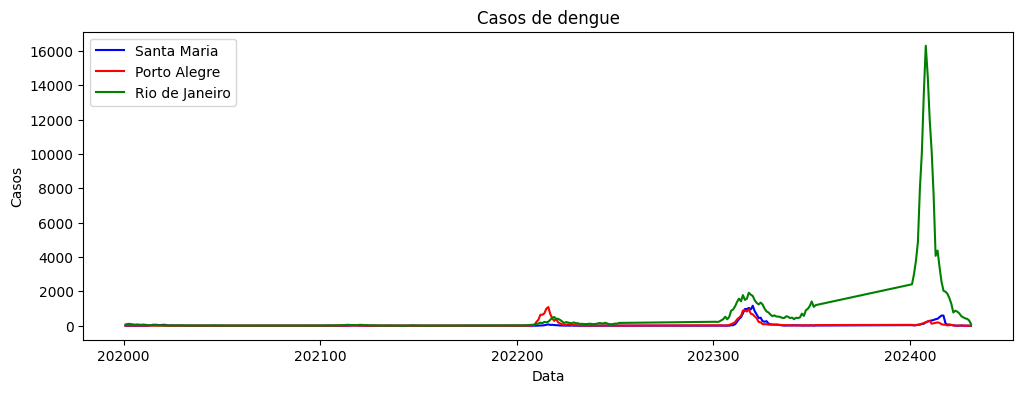

In [50]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the data from the first DataFrame
ax.plot(result.index, result['casos_sm'], color='blue', label='Santa Maria')
ax.plot(result.index, result['casos_poa'], color='red', label='Porto Alegre')
ax.plot(result.index, result['casos_rj'], color='green', label='Rio de Janeiro')
ax.set_title(f'Casos de dengue')


# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Casos')

# Show the plot
plt.legend()
plt.show()

## Comparação incidências de dengue (>100k) dos 3 municípios (RJ, POA, SM)

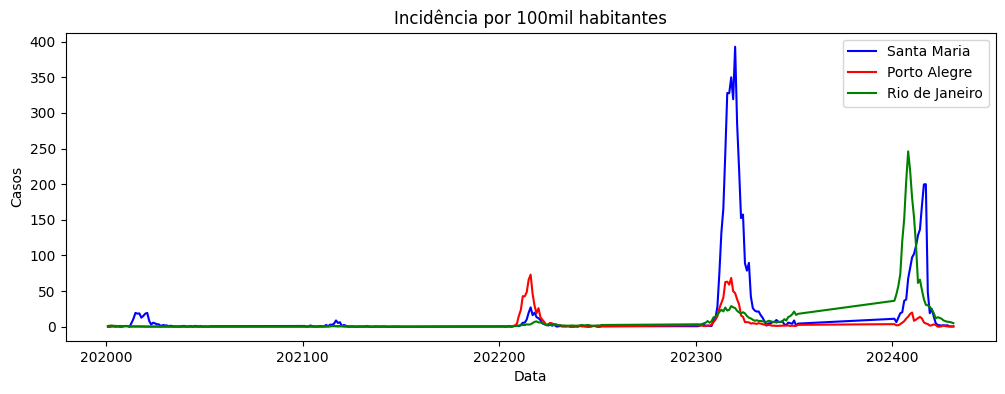

In [51]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the data from the first DataFrame
ax.plot(result.index, result['p_inc100k_sm'], color='blue', label='Santa Maria')
ax.plot(result.index, result['p_inc100k_poa'], color='red', label='Porto Alegre')
ax.plot(result.index, result['p_inc100k_rj'], color='green', label='Rio de Janeiro')

# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Casos')
ax.set_title(f'Incidência por 100mil habitantes')

# Show the plot
plt.legend()
plt.show()

In [52]:
result.to_csv("downloadedInfoDengueData.CSV")